<a href="https://colab.research.google.com/github/jasonbuchanan145/Data-Modeling/blob/main/hugging_face.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib
from google.colab import drive
drive.mount('/content/drive')
from google.colab import auth
from googleapiclient.discovery import build

auth.authenticate_user()
drive_service = build('drive', 'v3')

!pip install datasets
!pip install huggingface_hub
!pip install py-solc-x
!pip install -U bitsandbytes
!pip install slither-analyzer
!solc-select install 0.8.28
!pip install trl
!pip install tensorboard
!solc-select use 0.8.28


In [ ]:
from google.colab import files

# Create a working directory for our Solidity project
!mkdir -p solidity_project
%cd solidity_project

# Initialize npm project and install dependencies
!npm init -y
!npm install --save-dev hardhat @nomicfoundation/hardhat-toolbox @openzeppelin/contracts
!npm install @chainlink/contracts # Add other common dependencies as needed


# Create contracts directory
!mkdir -p contracts

In [ ]:
import logging
log = logging.getLogger(__name__)
log.setLevel(logging.DEBUG)
global file_handler
# Create a file handler and set the filename
file_handler = logging.FileHandler('/content/log_epoch.log')

# Create a formatter and add it to the handler
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
file_handler.setFormatter(formatter)

# Add the handler to the logger
log.addHandler(file_handler)
log.propagate = False

In [ ]:
# Standard libraries
import os
import re
import json
import tempfile
import shutil
import glob
import subprocess
import requests
import matplotlib.pyplot as plt
import hashlib
from pathlib import Path

# PyTorch and related
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.amp import autocast
from torch.amp import GradScaler
from datasets import load_dataset, Dataset as HFDataset # Import HFDataset from datasets
# Transformers and TRL
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TFAutoModelForMaskedLM,
    GenerationConfig,
    pipeline,
    BitsAndBytesConfig
)
from trl import (
    PPOTrainer,
    PPOConfig,
    AutoModelForCausalLMWithValueHead,
    create_reference_model
)

# Datasets
from datasets import load_dataset

# Solidity Compiler
from solcx import compile_standard, install_solc

# BitsAndBytes
from bitsandbytes.optim import Adam8bit

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
# Set the path to save the best model
output_dir = "/content/drive/MyDrive/llama_generated_contracts/explanations"

In [ ]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
model_name = "Qwen/Qwen2.5-Coder-7B-instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
quantization_config = BitsAndBytesConfig(load_in_8bit=True)
model = AutoModelForCausalLMWithValueHead.from_pretrained(
    model_name,
    device_map="auto",
    quantization_config=quantization_config
)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/27.8k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.33G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.09G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

In [ ]:
# Create a new model instance on CPU
with torch.device("cpu"):
    reference_model = AutoModelForCausalLMWithValueHead.from_pretrained(
        model_name,
        device_map="cpu"
      )

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
def make_prompts(file_path):
  dataset = []
  with open(file_path, 'r') as file:
      for line in file:
          line = line.strip()
          if line.startswith('"') and line.endswith('"'):
              # Remove the surrounding quotes
              clean_line = line[1:-1]
              clean_line = "Using Solidity and having your code start with \"// Begin Smart Contract\" and ending with \"//End Smart Contract\" as comments "+clean_line
              dataset.append(clean_line)
  return dataset
prompts = make_prompts("/content/drive/MyDrive/prompts.txt")
validation_prompts = make_prompts("/content/drive/MyDrive/validation_prompts.txt")

In [ ]:
def setup_hardhat_environment():
    """
    Set up the initial Hardhat environment with common dependencies.
    Run this once at the beginning of your notebook.
    """
    import subprocess
    import os

    # Create directories relative to the project root
    os.makedirs('./contracts', exist_ok=True)
    os.makedirs('./artifacts', exist_ok=True)

    log.info("Installing common Solidity dependencies...")
    dependencies = [
        "hardhat",
        "@nomicfoundation/hardhat-toolbox",
        "@openzeppelin/contracts",
        "@chainlink/contracts"
    ]

    install_cmd = ["npm", "install", "--save-dev"] + dependencies
    process = subprocess.run(install_cmd, capture_output=True, text=True)

    if process.returncode != 0:
        log.info(f"Error installing dependencies: {process.stderr}")
        return False

    # Create hardhat.config.js with relative paths for sources and artifacts
    hardhat_config = '''
module.exports = {
  solidity: {
    version: "0.8.20",
    settings: {
      optimizer: {
        enabled: true,
        runs: 200
      },
      evmVersion: "paris"
    }
  },
  paths: {
    sources: "./contracts",
    artifacts: "./artifacts"
  },
  networks: {
    hardhat: {
      chainId: 1337
    }
  },
  mocha: {
    timeout: 40000
  }
};
'''

    with open('hardhat.config.js', 'w') as f:
        f.write(hardhat_config)

    log.info("Hardhat environment setup complete")
    return True

setup_hardhat_environment()
def evaluate_contract_hard(contract_source, full_response):
    """
    Evaluate a Solidity contract by resolving additional dependencies,
    compiling it with Hardhat, and validating the generated artifact.

    Returns:
        dict: {
            "reward": int (10 for success, negative for errors),
            "error_token_indices": list of token indices corresponding to problematic error snippets
        }
    """
    try:
        # Write the contract source to a file in the contracts directory
        contract_path = Path('./contracts/MainContract.sol')
        with open(contract_path, 'w') as f:
            f.write(contract_source)

        # Detect contract name
        contract_name_match = re.search(r'contract\s+(\w+)(?:\s+is\s+[^{]+)?\s*{', contract_source)
        if contract_name_match:
            contract_name = contract_name_match.group(1)
            log.info(f"Detected contract name: {contract_name}")
        else:
            contract_name = "MainContract"
            log.info(f"Could not detect contract name, using default: {contract_name}")

        # Detect import statements that may require additional npm packages
        import_pattern = re.compile(r'import\s+(?:{[^}]*}\s+from\s+)?[\'"](.+?)[\'"];')
        imports = import_pattern.findall(contract_source)

        # Map import prefixes to their corresponding npm package names
        dependency_map = {
            '@openzeppelin/': '@openzeppelin/contracts',
            '@chainlink/': '@chainlink/contracts',
            '@uniswap/': '@uniswap/v3-core',
            'hardhat/': '@nomicfoundation/hardhat-toolbox',
            '@aave/': '@aave/protocol-v2',
            '@compound-finance/': '@compound-finance/contracts',
            '@balancer-labs/': '@balancer-labs/v2-solidity-utils',
            '@1inch/': '@1inch/solidity-utils',
            '@sushiswap/': '@sushiswap/core'
        }

        dependencies_to_install = set()
        for imp in imports:
            for prefix, package in dependency_map.items():
                if prefix in imp:
                    dependencies_to_install.add(package)

        if dependencies_to_install:
            log.info(f"Installing additional dependencies: {', '.join(dependencies_to_install)}")
            install_cmd = ['npm', 'install', '--save-dev'] + list(dependencies_to_install)
            install_process = subprocess.run(install_cmd, capture_output=True, text=True)
            if install_process.returncode != 0:
                log.info(f"Warning: Failed to install some dependencies: {install_process.stderr}")

        # Clean the environment and compile the contract
        subprocess.run(['npx', 'hardhat', 'clean'], capture_output=True)
        compile_process = subprocess.run(
            ['npx', 'hardhat', 'compile', '--force'],
            capture_output=True,
            text=True
        )

        # If compilation fails, extract error token indices
        if compile_process.returncode != 0:
            log.info("Compilation failed")
            log.info(f"STDOUT: {compile_process.stdout}")
            log.info(f"STDERR: {compile_process.stderr}")

            # Extract error snippets using regex matching lines starting with a number then "|"
            stderr = compile_process.stderr
            pattern = r'^\s*\d+\s*\|\s*(.+)$'
            error_snippets = re.findall(pattern, stderr, re.MULTILINE)
            log.info(f"Extracted error snippets: {error_snippets}")
            error_token_indices = []
            # Use offset mapping for precise mapping.
            encoded = tokenizer(full_response, return_offsets_mapping=True)
            offsets = encoded.get('offset_mapping', None)
            if offsets and isinstance(offsets[0], int):
                # This is a single list of integers; wrap it.
                offsets = [tuple(offsets)]
            elif offsets and isinstance(offsets[0], (list, tuple)) and isinstance(offsets[0][0], int):
                # Offsets are already in the correct format; do nothing.
                pass
            else:
              log.info("Offset mapping not available or in unexpected format: %s. Falling back to cumulative-length mapping.", repr(offsets))
              # Fallback: create offsets by cumulative token lengths.
              tokens = tokenizer(full_response, return_tensors="pt").input_ids[0]
              decoded_tokens = tokenizer.batch_decode(tokens, skip_special_tokens=True)
              offsets = []
              current_pos = 0
              for token in decoded_tokens:
                  token_len = len(token)
                  offsets.append((current_pos, current_pos + token_len))
                  current_pos += token_len
            # For each error snippet, find its character span and then map to token indices.
            for snippet in error_snippets:
                snippet_start = full_response.find(snippet)
                if snippet_start != -1:
                    snippet_end = snippet_start + len(snippet)
                    for i, (token_start, token_end) in enumerate(offsets):
                        if token_end > snippet_start and token_start < snippet_end:
                            error_token_indices.append(i)

            error_token_indices = sorted(set(error_token_indices))
            error_count = len(error_snippets)
            # Scale the reward by the number of errors (e.g. -10 per error)
            return {"reward": -1, "error_token_indices": error_token_indices, "error_count": error_count}

        # Verify that the artifact was created
        artifact_dir = Path('artifacts/contracts/MainContract.sol')
        artifact_files = list(artifact_dir.glob('*.json'))
        if not artifact_files:
            log.info("Compilation appeared successful but no artifacts were generated")
            return {"reward": 0, "error_token_indices": [], "error_count": 0}

        log.info("Contract compiled successfully")
        return {"reward": 0.01, "error_token_indices": [], "error_count": 0}

    except Exception as e:
        log.info(f"Error during contract evaluation: {str(e)}")
        return {"reward": -2, "error_token_indices": [], "error_count": 1}

    finally:
        import shutil
        contract_path = Path('contracts/MainContract.sol')
        if contract_path.exists():
            os.remove(contract_path)
        artifacts_path = Path('artifacts/contracts/MainContract.sol')
        if artifacts_path.exists():
            shutil.rmtree(artifacts_path)



def evaluate_contract(contract_source):
    return evaluate_contract_hard(contract_source)

In [ ]:
model.generation_config = GenerationConfig.from_model_config(model.config)

train_dataset = HFDataset.from_dict({"query": prompts})


formatted_prompts = [{"prompt": prompt} for prompt in prompts]
train_dataset = HFDataset.from_list(formatted_prompts)

ppo_config = PPOConfig(
    learning_rate=1e-5,
    batch_size=1,
    mini_batch_size=1,
    num_ppo_epochs=4,
    gamma=1.0,
    lam=0.95,
    cliprange=0.3,
    cliprange_value=0.3,
    vf_coef=0.1,
    seed=42,
    output_dir=output_dir
)
class CustomPPOTrainer(PPOTrainer):
    def __init__(self, *args, **kwargs):
        # Initialize without calling parent init as before
        from transformers import TrainingArguments
        self.args = kwargs.pop('args', None) or TrainingArguments("./output")
        self.policy_model = kwargs.pop('model')
        self.ref_model = kwargs.pop('ref_model')
        self.train_dataset = kwargs.pop('train_dataset')
        self.processing_class = kwargs.pop('processing_class')
        self.setup_data_loader()
        # Initialize the GradScaler for mixed precision training
        self.scaler = GradScaler()
        self.setup_optimizers()  # Modified to use a memory-efficient optimizer

    def setup_data_loader(self):
        from torch.utils.data import DataLoader
        self.dataloader = DataLoader(
            self.train_dataset,
            batch_size=self.args.batch_size,
            shuffle=True
        )

    def setup_optimizers(self):
        # Instead of torch.optim.Adam, use the 8-bit Adam optimizer from bitsandbytes
        self.optimizer = Adam8bit(
            self.policy_model.parameters(),
            lr=self.args.learning_rate
        )

    def step(self, prompts, responses, rewards):
          # Ensure correct data type for responses and prompts
          if hasattr(responses, 'dtype') and responses.dtype == torch.float16:
              responses = responses.float()
          if hasattr(prompts, 'dtype') and prompts.dtype == torch.float16:
              prompts = prompts.float()

          # Turn off autocast during loss computation
          with torch.amp.autocast("cuda", enabled=False):
              loss = self.compute_loss(prompts, responses, rewards)

          # Backward pass
          loss.backward()

          # Convert gradients to correct dtype and step the optimizer
          for group in self.optimizer.param_groups:
              for p in group['params']:
                  if p.grad is not None:
                      p.grad = p.grad.to(p.dtype)

          self.optimizer.step()
          self.optimizer.zero_grad(set_to_none=True)

          return {"loss": loss.item()}

    def compute_loss(self, prompt_ids, response_ids, rewards):
      pad_id = self.processing_class.pad_token_id
      attention_mask = (response_ids != pad_id).to(response_ids.device, dtype=torch.long)

      outputs = self.policy_model(
          input_ids=response_ids,
          attention_mask=attention_mask,
          use_cache=False,
          return_dict=True
      )
      # Check if outputs is a dict; if not, extract values from the tuple.
      if isinstance(outputs, dict):
          logits = outputs["logits"]
          value_predictions = outputs.get("value", None)
      else:
          logits = outputs[0]
          value_predictions = outputs[1] if len(outputs) > 1 else None

      new_policy_log_probs = torch.nn.functional.log_softmax(logits, dim=-1)
      new_log_probs = new_policy_log_probs.gather(
          dim=-1, index=response_ids.unsqueeze(-1)
      ).squeeze(-1)

      with torch.no_grad():
          cpu_response_ids = response_ids.to("cpu")
          cpu_attention_mask = attention_mask.to("cpu")
          ref_outputs = self.ref_model(
              input_ids=cpu_response_ids,
              attention_mask=cpu_attention_mask,
              use_cache=False,
              return_dict=True
          )
          if isinstance(ref_outputs, dict):
              ref_logits = ref_outputs["logits"]
          else:
              ref_logits = ref_outputs[0]

      ref_logits = ref_logits.to(response_ids.device)
      old_policy_log_probs = torch.nn.functional.log_softmax(ref_logits, dim=-1)
      old_log_probs = old_policy_log_probs.gather(
          dim=-1, index=response_ids.unsqueeze(-1)
      ).squeeze(-1)

      ratios = torch.exp(new_log_probs - old_log_probs)

      rewards_tensor = torch.tensor(rewards, dtype=torch.float32, device=ratios.device)
      if rewards_tensor.dim() == 1:
          advantage = rewards_tensor.unsqueeze(1).expand_as(ratios)
      else:
          advantage = rewards_tensor.expand_as(ratios)

      clip_epsilon = 0.2
      clipped_ratios = torch.clamp(ratios, 1 - clip_epsilon, 1 + clip_epsilon)
      surrogate_loss = torch.min(ratios * advantage, clipped_ratios * advantage)
      loss_policy = -torch.mean(surrogate_loss)

      if value_predictions is not None:
          loss_value = torch.nn.functional.mse_loss(value_predictions.squeeze(-1), rewards_tensor)
      else:
          loss_value = 0.0

      kl_div = torch.nn.functional.kl_div(
          new_policy_log_probs, old_policy_log_probs.exp(), reduction='batchmean'
      )
      kl_coef = 0.1
      loss = loss_policy + loss_value + kl_coef * kl_div

      log.info(f"compute_loss: loss_policy={loss_policy.item():.4f}, loss_value={loss_value:.4f}, kl_div={kl_div.item():.4f}, total_loss={loss.item():.4f}")
      return loss




# Use the custom trainer if needed
ppo_trainer = CustomPPOTrainer(
    args=ppo_config,
    model=model,
    ref_model=reference_model,
    reward_model=evaluate_contract,
    train_dataset=train_dataset,
    processing_class=tokenizer
)

In [ ]:
def generate_text(prompt, max_new_tokens=2000, temperature=0.7):
    """Generate text using the official Qwen pattern"""
    # Format messages properly
    messages = [
            {"role": "system", "content": "You are an expert Solidity developer specialized in writing secure, efficient smart contracts. "+
            "These contracts are intended to test your capabilities so ensure that you always provide complete, working code that compiles with no placeholders. "
            "If there are values that you don't know, for example what to set an integer value to, just set it to any number. If you need a wallet id to accompilsh a task use GBH4TZYZ4IRCPO44CBOLFUHULU2WGALXTAVESQA6432MBJMABBB4GIYI"},
            {"role": "user", "content": prompt}
        ]
    # Apply chat template as shown in quickstart
    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )

    # Create inputs
    model_inputs = tokenizer([text], return_tensors="pt").to("cuda:0")

    # Generate with proper settings
    with torch.no_grad():
        generated_ids = model.generate(
            **model_inputs,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            do_sample=True,
            top_p=0.95,
            repetition_penalty=1.1
        )

    # Extract only the new tokens
    generated_ids = [
        output_ids[len(input_ids):]
        for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
    ]

    # Decode only the response portion
    response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

    return response

In [ ]:
def extract_contract_code(response_text):
    """Extract the contract code from model response with improved pattern matching.
    Priority order:
    1. Find the last code block (```solidity ... ```)
    2. Look for Begin/End Smart Contract markers
    """
    # Case 1: Look for the LAST code block with solidity language marker
    code_blocks = code_blocks = re.findall(r"```solidity\s*(.*?)```", response_text, re.DOTALL)
    if code_blocks:
        # Get the last code block (highest priority)
        return code_blocks[-1]


    # Case 2: Look for markers outside or inside code blocks - use LAST occurrence
    start_marker = "// Begin Smart Contract"
    end_marker = "// End Smart Contract"

    # Find the LAST occurrence of the start marker
    start_idx = response_text.rfind(start_marker)

    # Find the LAST occurrence of the end marker
    end_idx = response_text.rfind(end_marker)

    if start_idx != -1 and end_idx != -1 and start_idx < end_idx:
        # Check if there's a closing bracket on the next line after the end marker
        end_marker_pos = end_idx + len(end_marker)
        next_closing_bracket = response_text[end_marker_pos:].find("}")

        if next_closing_bracket != -1 and response_text[end_marker_pos:end_marker_pos+next_closing_bracket].strip() == "":
            # Include the closing bracket if it's on the next line
            return response_text[start_idx:end_marker_pos + next_closing_bracket + 1]
        else:
            return response_text[start_idx:end_marker_pos]

    # Case 3 look for just tripple backticks (happens if the LLM writes a smart contract in javascript and ignores instructions or starts to degrade)
    code_blocks = code_blocks = re.findall(r"```\s*(.*?)```", response_text, re.DOTALL)
    if code_blocks:
        return code_blocks[-1]

    # Case 4: No markers and no code blocks
    log.info("No valid Solidity contract found in response")
    return None

In [ ]:
# Function to clean up old checkpoints
def cleanup_old_checkpoints(checkpoint_dir="/content/drive/MyDrive/checkpoints",keep_last_n=1):
    # Get all checkpoint files sorted by creation time (newest first)
    all_checkpoints = sorted(
        glob.glob(f"{checkpoint_dir}/checkpoint_*.pt"),
        key=os.path.getctime,
        reverse=True
    )

    # Get all model directories sorted by creation time (newest first)
    all_model_dirs = sorted(
        [d for d in glob.glob(f"{checkpoint_dir}/model_epoch_*_prompt_*") if os.path.isdir(d)],
        key=os.path.getctime,
        reverse=True
    )

    # Keep the N newest checkpoints, delete the rest
    if len(all_checkpoints) > keep_last_n:
        for old_checkpoint in all_checkpoints[keep_last_n:]:
            try:
                os.remove(old_checkpoint)
                log.info(f"Deleted old checkpoint: {old_checkpoint}")
            except Exception as e:
                log.warning(f"Failed to delete {old_checkpoint}: {e}")

    # Keep the N newest model directories, delete the rest
    if len(all_model_dirs) > keep_last_n:
        for old_model_dir in all_model_dirs[keep_last_n:]:
            try:
                shutil.rmtree(old_model_dir)
                log.info(f"Deleted old model directory: {old_model_dir}")
            except Exception as e:
                log.warning(f"Failed to delete {old_model_dir}: {e}")
    drive_service.files().emptyTrash().execute()

In [ ]:
def compute_validation_loss(inputs, contract_tokens, token_rewards, ppo_trainer):
    window_size = 256
    step_size = 128
    window_losses = []
    with torch.no_grad():
        for start_idx in range(0, contract_tokens.size(1), step_size):
            end_idx = min(start_idx + window_size, contract_tokens.size(1))
            if end_idx - start_idx < 32:
                continue
            window_ids = contract_tokens[:, start_idx:end_idx].to("cuda:0")
            window_token_rewards = token_rewards[start_idx:end_idx]
            avg_window_reward = sum(window_token_rewards) / len(window_token_rewards)
            loss = ppo_trainer.compute_loss(inputs.input_ids, window_ids, [avg_window_reward])
            window_losses.append(loss.item())
    avg_loss = sum(window_losses) / len(window_losses) if window_losses else 0
    return avg_loss

In [ ]:
def validate_prompt(prompt, model, tokenizer):
    full_response = generate_text(prompt, max_new_tokens=2000, temperature=0.7)
    log.info("Validation full response:\n" + full_response)
    contract_code = extract_contract_code(full_response)
    if not contract_code:
        log.info("No contract code extracted for validation prompt")
        return -10, 1, 0
    eval_result = evaluate_contract_hard(contract_code, full_response)
    overall_reward = eval_result["reward"]
    error_count = eval_result["error_count"]
    error_token_indices = eval_result["error_token_indices"]
    log.info(f"Validation evaluation result: reward = {overall_reward}")

    prompt_inputs = tokenizer(prompt, return_tensors="pt").to("cuda:0")
    contract_tokens = tokenizer(contract_code, return_tensors="pt").input_ids[0]
    token_rewards = []
    for i, token_id in enumerate(contract_tokens):
        if i in error_token_indices:
            token_rewards.append(-1)
        else:
            token_rewards.append(0 if overall_reward < 0 else 0.01)
    assert len(token_rewards) == contract_tokens.shape[0], "Mismatch between token count and reward vector length"

    val_loss = compute_validation_loss(prompt_inputs, contract_tokens.unsqueeze(0).to("cuda:0"), token_rewards, ppo_trainer)
    return overall_reward, error_count, val_loss


In [ ]:
def plot_loss_performance(epochs, training_losses, validation_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, training_losses, marker='o', linestyle='-', label='Average Training Loss')
    plt.plot(epochs, validation_losses, marker='o', linestyle='-', label='Average Validation Loss')
    for i, (train_loss, val_loss) in enumerate(zip(training_losses, validation_losses)):
        plt.text(epochs[i], train_loss, f"{train_loss:.4f}", ha='center', va='bottom')
        plt.text(epochs[i], val_loss, f"{val_loss:.4f}", ha='center', va='bottom')
    plt.title('Average Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.xticks(epochs)
    plt.savefig('/content/drive/MyDrive/average_loss.png')
    plt.show()


In [ ]:
def process_prompt(prompt, model, tokenizer, ppo_trainer, epoch, prompt_idx, compilation_errors):
    # Generate full response from the model.
    full_response = generate_text(prompt, max_new_tokens=2000, temperature=0.7)
    log.info("Full response:\n" + full_response)

    # Extract the contract code from the full response.
    contract_code = extract_contract_code(full_response)
    if not contract_code:
        log.info("No contract code extracted, punishing the entire response with -1 reward for all tokens")
        if epoch < len(compilation_errors):
            compilation_errors[epoch] += 1
        # Use the full response for tokenization.
        contract_tokens = tokenizer(full_response, return_tensors="pt").input_ids[0]
        # Every token gets a reward of -1.
        token_rewards = [-1] * contract_tokens.shape[0]
        overall_reward = -1
        # Here we define error_count as the number of tokens in the full response.
        error_count = 1
    else:
        log.info("Extracted contract code:\n" + contract_code)
        eval_result = evaluate_contract_hard(contract_code, full_response)
        overall_reward = eval_result["reward"]
        error_token_indices = eval_result["error_token_indices"]
        error_count = eval_result.get("error_count", 1)
        log.info(f"Evaluation result: reward = {overall_reward}, error token indices = {error_token_indices}")

        # Tokenize the extracted contract code exactly as compiled.
        contract_tokens = tokenizer(full_response, return_tensors="pt").input_ids[0]
        # Build token-level rewards based on error token indices.
        token_rewards = []
        for i, token_id in enumerate(contract_tokens):
            if i in error_token_indices:
                token_rewards.append(-1)
            else:
                # If overall_reward is negative, assign 0; if positive, assign a small positive reward.
                token_rewards.append(0 if overall_reward < 0 else 0.01)
    assert len(token_rewards) == contract_tokens.shape[0], "Mismatch between token count and reward vector length"

    # Prepare the prompt inputs.
    prompt_inputs = tokenizer(prompt, return_tensors="pt").to("cuda:0")
    prompt_loss = update_model_with_sliding_window(
        prompt_inputs,
        contract_tokens.unsqueeze(0).to("cuda:0"),
        token_rewards,
        ppo_trainer
    )
    torch.cuda.empty_cache()

    if overall_reward < 0:
        compilation_errors[epoch] += error_count

    return overall_reward, prompt_loss




def update_model_with_sliding_window(inputs, contract_tokens, token_rewards, ppo_trainer):
    window_size = 256
    step_size = 128  # 50% overlap
    window_losses = []
    for start_idx in range(0, contract_tokens.size(1), step_size):
        end_idx = min(start_idx + window_size, contract_tokens.size(1))
        if end_idx - start_idx < 32:
            continue  # Skip very short windows

        window_ids = contract_tokens[:, start_idx:end_idx].to("cuda:0")
        window_token_rewards = token_rewards[start_idx:end_idx]
        avg_window_reward = sum(window_token_rewards) / len(window_token_rewards)

        stats = ppo_trainer.step(
            inputs.input_ids,
            window_ids,
            [avg_window_reward]
        )
        window_losses.append(stats.get('loss', 0))
        log.info(f"Window {start_idx}-{end_idx}: avg_token_reward: {avg_window_reward:.4f}, loss: {stats.get('loss', 0):.4f}")
        torch.cuda.empty_cache()
    avg_loss = sum(window_losses) / len(window_losses) if window_losses else 0
    return avg_loss


def save_checkpoint(checkpoint_dir, epoch, prompt_idx, global_step, running_loss, contracts_with_errors, model, ppo_trainer, compilation_errors):
    """Save model checkpoint, including running_loss and contracts_with_errors."""
    checkpoint_path = f"{checkpoint_dir}/checkpoint_epoch_{epoch}_prompt_{prompt_idx}.pt"
    torch.save({
        'global_step': global_step,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': ppo_trainer.optimizer.state_dict(),
        'compilation_errors': compilation_errors,
        'running_loss': running_loss,  # Save the cumulative training loss so far.
        'contracts_with_errors': contracts_with_errors,  # Save the number of contracts with errors.
    }, checkpoint_path)
    log.info(f"Saved checkpoint to {checkpoint_path}")

    # Optionally, save in HF format as well (includes both base model and value head).
    model_save_path = f"{checkpoint_dir}/model_epoch_{epoch}_prompt_{prompt_idx}"
    model.save_pretrained(model_save_path)
    tokenizer.save_pretrained(model_save_path)
    log.info(f"Saved model to {model_save_path}")

    # Clean up old checkpoints after a successful save.
    cleanup_old_checkpoints(checkpoint_dir=checkpoint_dir)


def find_latest_checkpoint(checkpoint_dir):
    """
    Find and load the latest checkpoint if available.
    Returns a tuple: (latest_checkpoint, starting_epoch, starting_prompt_idx,
                       compilation_errors, global_step, running_loss, contracts_with_errors)
    """
    checkpoint_files = glob.glob(f"{checkpoint_dir}/checkpoint_*.pt")
    if not checkpoint_files:
        # Return default values if no checkpoint exists.
        return None, 0, 0, [], 0, 0, 0

    latest_checkpoint = max(checkpoint_files, key=os.path.getctime)
    match = re.search(r'checkpoint_epoch_(\d+)_prompt_(\d+)', latest_checkpoint)
    if not match:
        return None, 0, 0, [], 0, 0, 0

    starting_epoch = int(match.group(1))
    # Resume from the prompt after the saved checkpoint.
    starting_prompt_idx = int(match.group(2)) + 1

    # Load the checkpoint.
    checkpoint = torch.load(latest_checkpoint)
    compilation_errors = checkpoint.get('compilation_errors', [])
    global_step = checkpoint.get('global_step', 0)
    running_loss = checkpoint.get('running_loss', 0)
    contracts_with_errors = checkpoint.get('contracts_with_errors', 0)

    print(f"Resuming from checkpoint: {latest_checkpoint}")
    print(f"Starting from epoch {starting_epoch + 1}, prompt {starting_prompt_idx + 1}")

    return latest_checkpoint, starting_epoch, starting_prompt_idx, compilation_errors, global_step, running_loss, contracts_with_errors


def load_checkpoint(checkpoint_path, model, ppo_trainer):
    """
    Load model and optimizer state from checkpoint and return a tuple:
    (running_loss, contracts_with_errors)
    """
    if not checkpoint_path:
        return 0, 0  # defaults if no checkpoint is provided.
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    ppo_trainer.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    running_loss = checkpoint.get('running_loss', 0)
    contracts_with_errors = checkpoint.get('contracts_with_errors', 0)
    return running_loss, contracts_with_errors



def save_final_model(checkpoint_dir, model, tokenizer, ppo_trainer, compilation_errors, global_step):
    """Save the final model and generate performance plot."""
    # Save final checkpoint
    final_checkpoint_path = f"{checkpoint_dir}/checkpoint_final.pt"
    torch.save({
        'global_step': global_step,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': ppo_trainer.optimizer.state_dict(),
        'compilation_errors': compilation_errors,
    }, final_checkpoint_path)
    log.info(f"Saved final checkpoint to {final_checkpoint_path}")

    # Save final model in HF format
    model.save_pretrained(f"{checkpoint_dir}/model_final")
    tokenizer.save_pretrained(f"{checkpoint_dir}/model_final")



def plot_performance(num_epochs, training_errors, validation_errors):
    log.debug(f"Training errors: {training_errors}")
    log.debug(f"Validation errors: {validation_errors}")
    epochs = range(1, num_epochs + 1)
    plt.figure(figsize=(10, 6))

    # Plot training errors and annotate data points
    plt.plot(epochs, training_errors, marker='o', linestyle='-', label='Training Compilation Errors')
    for i, train_err in enumerate(training_errors, start=1):
        plt.text(i, train_err, f"{train_err:.4f}", ha='center', va='bottom')

    # Plot and annotate validation errors only if provided
    if validation_errors is not None and len(validation_errors) > 0:
        plt.plot(epochs, validation_errors, marker='o', linestyle='-', label='Validation Compilation Errors')
        for i, val_err in enumerate(validation_errors, start=1):
            plt.text(i, val_err, f"{val_err:.4f}", ha='center', va='bottom')

    plt.title('Compilation Errors per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Number of Compilation Errors')
    plt.legend()
    plt.grid(True)
    plt.xticks(epochs)
    plt.savefig('/content/drive/MyDrive/compilation_errors.png')
    plt.show()

def train(prompts, val_prompts, num_epochs=5, save_every=20, checkpoint_dir="/content/drive/MyDrive/checkpoints"):
    os.makedirs(checkpoint_dir, exist_ok=True)
    compilation_errors = [0 for _ in range(num_epochs)]
    val_errors = [0 for _ in range(num_epochs)]
    training_losses = []   # Average training loss per epoch
    validation_losses = [] # Average validation loss per epoch
    global_step = 0
    prev_compile_status = [None] * len(prompts)

    # Attempt to load a previous checkpoint.
    latest_checkpoint, starting_epoch, starting_prompt_idx, loaded_errors, loaded_step, loaded_running_loss, loaded_contracts_with_errors = find_latest_checkpoint(checkpoint_dir)
    if latest_checkpoint:
        running_loss, contracts_with_errors = load_checkpoint(latest_checkpoint, model, ppo_trainer)
        compilation_errors = loaded_errors if loaded_errors else compilation_errors
        global_step = loaded_step
    else:
        running_loss = 0
        contracts_with_errors = 0

    try:
        for epoch in range(starting_epoch, num_epochs):
            model.train()
            log.info(f"Epoch {epoch+1}/{num_epochs}")
            current_compile_status = [None] * len(prompts)
            epoch_train_losses = []  # To track the per-prompt training loss in this epoch

            # If resuming an interrupted epoch, keep the saved values; otherwise, start fresh.
            if epoch != starting_epoch:
                running_loss = 0
                contracts_with_errors = 0
            start_idx = starting_prompt_idx if epoch == starting_epoch else 0

            for i, prompt in enumerate(prompts[start_idx:], start=start_idx):
                global_step += 1
                log.info(f"Processing prompt {i+1}/{len(prompts)}")

                # process_prompt performs the forward/backward pass and returns overall_reward and prompt_loss.
                overall_reward, prompt_loss = process_prompt(prompt, model, tokenizer, ppo_trainer, epoch, i, compilation_errors)

                running_loss += prompt_loss
                epoch_train_losses.append(prompt_loss)
                # Determine if the prompt's contract compiled successfully.
                current_compile_status[i] = (overall_reward > 0)

                # Count this contract as having an error if overall_reward is not positive.
                if overall_reward <= 0:
                    contracts_with_errors += 1

                # Save checkpoint periodically.
                if global_step % save_every == 0:
                    save_checkpoint(checkpoint_dir, epoch, i, global_step, running_loss, contracts_with_errors, model, ppo_trainer, compilation_errors)

            # Save an extra checkpoint at the end of the training set (before validation).
            save_checkpoint(checkpoint_dir, epoch, i, global_step, running_loss, contracts_with_errors, model, ppo_trainer, compilation_errors)

            # Compute and log the average training loss for this epoch.
            avg_epoch_train_loss = sum(epoch_train_losses) / len(epoch_train_losses) if epoch_train_losses else 0
            training_losses.append(avg_epoch_train_loss)
            print(f"Epoch {epoch+1}: Average Training Loss = {avg_epoch_train_loss:.4f}")
            print(f"Number of training compilation errors for this epoch: {compilation_errors[epoch]}")
            print(f"Number of contracts with errors for this epoch: {contracts_with_errors}")

            # Optionally check for changes in compile status.
            if prev_compile_status[0] is not None:
                for idx, (prev_status, curr_status) in enumerate(zip(prev_compile_status, current_compile_status)):
                    if prev_status is False and curr_status is True:
                        print(f"Prompt {idx+1} now compiles but previously did not.")
            prev_compile_status = current_compile_status

            # Validation evaluation.
            epoch_val_errors = 0
            epoch_val_losses = []
            val_contracts_with_errors = 0
            if val_prompts:
                for val_prompt in val_prompts:
                    overall_reward, error_count, val_loss = validate_prompt(val_prompt, model, tokenizer)
                    epoch_val_errors += error_count
                    val_contracts_with_errors +=1
                    epoch_val_losses.append(val_loss)
                print(f"Epoch {epoch+1} validation compilation errors: {epoch_val_errors}")
                print(f"Epoch {epoch+1} contracts with compilation errors: {val_contracts_with_errors}")
            else:
                epoch_val_errors = 0
            val_errors[epoch] = epoch_val_errors
            avg_epoch_val_loss = sum(epoch_val_losses) / len(epoch_val_losses) if epoch_val_losses else 0
            validation_losses.append(avg_epoch_val_loss)
            print(f"Epoch {epoch+1}: Average Validation Loss = {avg_epoch_val_loss:.4f}")

            # Reset starting_prompt_idx after the first resumed epoch.
            starting_prompt_idx = 0

    finally:
        for log_file in glob.glob("/content/log*"):
            shutil.copy(log_file, "/content/drive/MyDrive/")
        save_final_model(checkpoint_dir, model, tokenizer, ppo_trainer, compilation_errors, global_step)
        plot_performance(num_epochs, compilation_errors, val_errors)
        plot_loss_performance(range(1, num_epochs+1), training_losses, validation_losses)

    return compilation_errors, val_errors, validation_losses, training_losses

Epoch 1: Average Training Loss = 0.0612
Number of training compilation errors for this epoch: 87
Number of contracts with errors for this epoch: 47
Epoch 1 validation compilation errors: 20
Epoch 1 contracts with compilation errors: 30
Epoch 1: Average Validation Loss = 0.0593
Epoch 2: Average Training Loss = 0.0764
Number of training compilation errors for this epoch: 91
Number of contracts with errors for this epoch: 49
Prompt 7 now compiles but previously did not.
Prompt 14 now compiles but previously did not.
Prompt 21 now compiles but previously did not.
Prompt 29 now compiles but previously did not.
Prompt 34 now compiles but previously did not.
Prompt 39 now compiles but previously did not.
Prompt 40 now compiles but previously did not.
Prompt 42 now compiles but previously did not.
Prompt 56 now compiles but previously did not.
Prompt 61 now compiles but previously did not.
Prompt 62 now compiles but previously did not.
Prompt 73 now compiles but previously did not.
Prompt 80 n

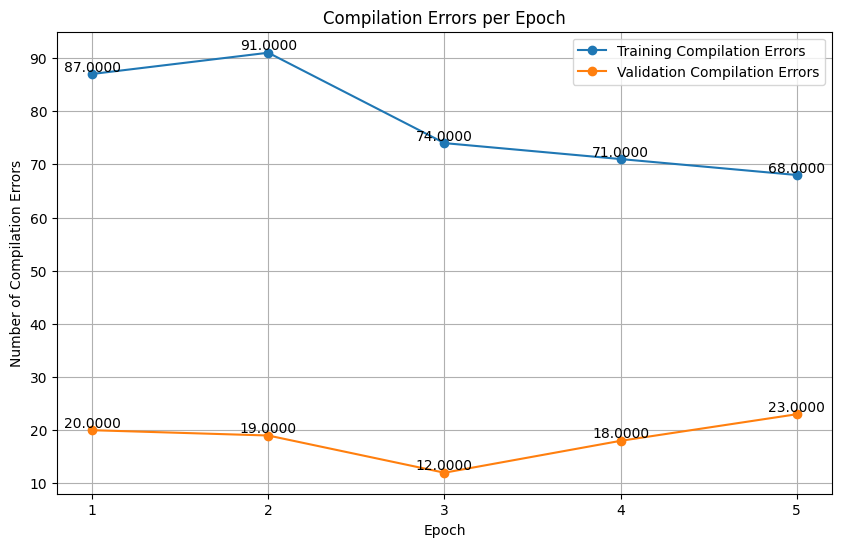

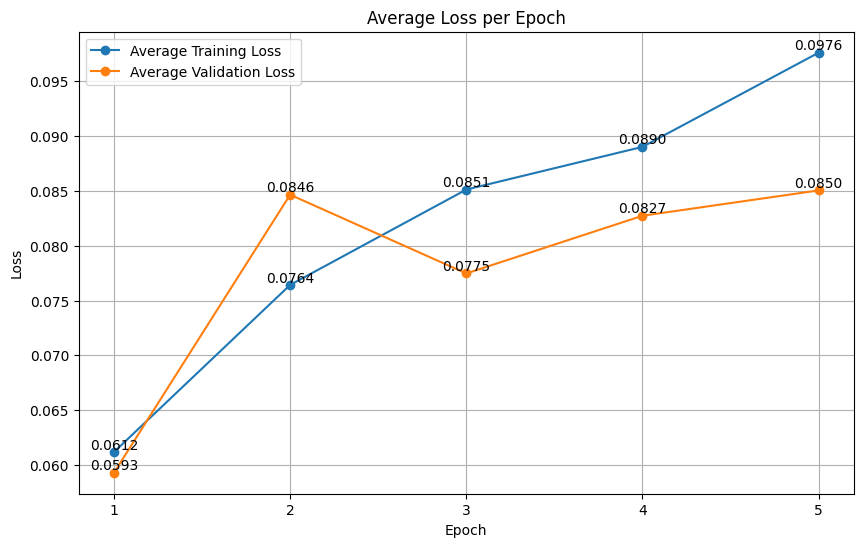

([87, 91, 74, 71, 68],
 [20, 19, 12, 18, 23],
 [0.05930124607506311,
  0.0846455094197558,
  0.07746544925658595,
  0.08272523925018807,
  0.08503613811814123],
 [0.06118544725201282,
  0.0764210671797653,
  0.08511261425051535,
  0.08900512881534012,
  0.09758912268411207])

In [ ]:
train(prompts,validation_prompts)